# 0. Solving 2D Wave Equation 
Training Neural Network to converge towards a well-defined solution of a PDE by way of minimising for the residuals across the spatio-temporal domain. Initial and Boundary conditions are met by introducing them into the loss function along with the PDE residuals. 

Numerical Method - Spectral Solver using FFT. <br>
Code taken from [this tutorial.](http://people.bu.edu/andasari/courses/numericalpython/Week12Lecture21/Spectral_wave2.py) <br>

Equation: 
```
u_tt = u_xx + u_yy on [-1,1] x [-1,1] 
```

Dirichlet Boundary Conditions : 
```
u=0
```

Initial Distribution :
```
 u(x,y,t=0) = exp(-40(x-4)^2 + y^2)
 ```

Initial Velocity Condition : 
```
u_t(x,y,t=0) = 0
```


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import h5py
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

data_path = 'data'

2022-03-04 17:14:11.367594: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Using TensorFlow v2.4.1


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Load conditions and the numerical solution 

The numerical solution was computed by solving the Wave Equation using a spectral solver. The solution will not form the training data but will be used for comparing against the output of the neural network. 

In [4]:
with h5py.File(join(data_path, 'Fusion/pde_2d_wave.h5'), 'r') as F:
    x = np.array(F['x'], dtype='float32')
    y = np.array(F['y'], dtype='float32')
    t = np.array(F['t'], dtype='float32')
    lb = np.array(F['lower_range'], dtype='float32')   # Lower Bounds of the domain
    ub = np.array(F['upper_range'], dtype='float32')   # Upper Bounds of the domain
    u_sol = np.array(F['U_sol'], dtype='float32')      # Solution of the 2D Wave Equation
    X_i = np.array(F['X_i'], dtype='float32')          # Data for Initial Input
    U_i = np.array(F['u_i'], dtype='float32')          # Data for Initial Input
    X_b = np.array(F['X_b'], dtype='float32')          # Data for Boundary Input
    X_f = np.array(F['X_f'], dtype='float32')          # Data for Domain Input



---

# 2. Build the network

We will build a neural network with 5 hidden layers.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
in_features = 3
num_layers = 5
out_features = 1
num_neurons = 100


npde_net = Sequential()
npde_net.add(Dense(100, activation='tanh', input_shape=(in_features,)))
for _ in range(num_layers - 1):
     npde_net.add(Dense(num_neurons, activation='tanh'))

npde_net.add(Dense(out_features))
```
    
</p>
</details>

In [ ]:
in_features = 3
num_layers = 5
out_features = 1
num_neurons = 100


npde_net = Sequential()
npde_net.add(Dense(100, activation='tanh', input_shape=(in_features,)))
for _ in range(num_layers - 1):
     npde_net.add(Dense(num_neurons, activation='tanh'))

npde_net.add(Dense(out_features))

In [5]:
optimizer = tf.keras.optimizers.Adam()

def train_step(X_i, Y_i, X_b, X_f):
    with tf.GradientTape() as tape:
        # recon loss
        recon_loss = npde_net(X_i) - Y_i

        # initial_cond_loss
        xi_ = tf.Variable(X_i[:, 0:1])
        yi_ = tf.Variable(X_i[:, 1:2])
        ti_ = tf.Variable(X_i[:, 2:3])
        with tf.GradientTape() as ti:
            ui = npde_net(tf.concat([xi_,yi_,ti_],1))

        ui_t = ti.gradient(ui, ti_)
        initial_cond_loss = ui_t - 0
        
        # boundary_loss
        ub = npde_net(X_b)
        bc_loss = ub - 0 

        # domain_loss
        xf_ = tf.Variable(X_f[:, 0:1])
        yf_ = tf.Variable(X_f[:, 1:2])
        tf_ = tf.Variable(X_f[:, 2:3])
        
        # build graph with GradientTape
        with tf.GradientTape() as tapex, tf.GradientTape() as tapey, tf.GradientTape() as tapet:
            with tf.GradientTape() as tape1:
                uf = npde_net(tf.concat([xf_,yf_,tf_],1))
        
            deriv1 = tape1.gradient(uf, {'x': xf_, 'y': yf_, 't':tf_})
        uf_xx = tapex.gradient(deriv1['x'], xf_) 
        uf_yy = tapey.gradient(deriv1['y'], yf_) 
        uf_tt = tapet.gradient(deriv1['t'], tf_)   

        pde_loss = uf_tt - (uf_xx + uf_yy)

        initial_loss = tf.reduce_mean(tf.math.square(recon_loss)) + tf.reduce_mean(tf.math.square(initial_cond_loss))
        boundary_loss = tf.reduce_mean(tf.math.square(bc_loss))
        domain_loss = tf.reduce_mean(tf.math.square(pde_loss))

        loss = initial_loss + boundary_loss + domain_loss 

    grads = tape.gradient(loss, npde_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, npde_net.trainable_variables))
    return loss

2022-03-04 17:14:12.699578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-04 17:14:12.700371: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-04 17:14:13.656871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-04 17:14:13.656901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-04 17:14:13.658507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-04 17:14:13.658573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-

In [7]:
interations = 5000
for i in range(interations):
    loss = train_step(X_i, U_i, X_b, X_f)
    if i % 100 == 0:
        print('epoch {}/{} ({:.2f}%): loss: {}'.format(i,interations, 100*(i/interations), loss.numpy()))
print('Final loss: {}'.format(loss.numpy()))

epoch 0/5000 (0.00%): loss: 0.17934705317020416
epoch 100/5000 (2.00%): loss: 0.009470456279814243
epoch 200/5000 (4.00%): loss: 0.009304364211857319
epoch 300/5000 (6.00%): loss: 0.00920688733458519
epoch 400/5000 (8.00%): loss: 0.009605527855455875
epoch 500/5000 (10.00%): loss: 0.008935756050050259
epoch 600/5000 (12.00%): loss: 0.008732271380722523
epoch 700/5000 (14.00%): loss: 0.008984295651316643
epoch 800/5000 (16.00%): loss: 0.008760987780988216
epoch 900/5000 (18.00%): loss: 0.008547356352210045
epoch 1000/5000 (20.00%): loss: 0.008569072932004929
epoch 1100/5000 (22.00%): loss: 0.008364925161004066
epoch 1200/5000 (24.00%): loss: 0.009111129678785801
epoch 1300/5000 (26.00%): loss: 0.007990489713847637
epoch 1400/5000 (28.00%): loss: 0.00769026530906558
epoch 1500/5000 (30.00%): loss: 0.007568339817225933
epoch 1600/5000 (32.00%): loss: 0.008952120319008827
epoch 1700/5000 (34.00%): loss: 0.006437415257096291
epoch 1800/5000 (36.00%): loss: 0.006023861002177
epoch 1900/5000 

---

# 3. Analyse results 

### Predict u from pairs of x, y, and t

In [8]:
X, Y = np.meshgrid(x, y)
XY_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
T_star = np.expand_dims(np.repeat(t, len(XY_star)), 1)
X_star_tiled = np.tile(XY_star, (len(t), 1))

X_star = np.hstack((X_star_tiled, T_star))
u_pred = npde_net(X_star).numpy()
u_pred = u_pred.reshape(u_sol.shape)

### Compare solution by the neural network against the Numerical solution. 

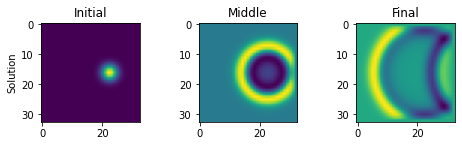

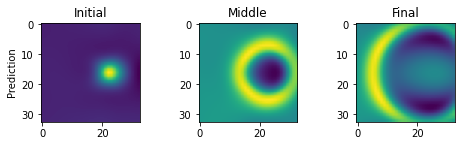

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2,3,1)
ax.imshow(u_sol[0])
ax.title.set_text('Initial')
ax.set_ylabel('Solution')

ax = fig.add_subplot(2,3,2)
ax.imshow(u_sol[int(len(u_sol)/2)])
ax.title.set_text('Middle')

ax = fig.add_subplot(2,3,3)
ax.imshow(u_sol[-1])
ax.title.set_text('Final')


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2,3,1)
ax.imshow(u_pred[0])
ax.title.set_text('Initial')
ax.set_ylabel('Prediction')

ax = fig.add_subplot(2,3,2)
ax.imshow(u_pred[int(len(u_sol)/2)])
ax.title.set_text('Middle')

ax = fig.add_subplot(2,3,3)
ax.imshow(u_pred[-1])
ax.title.set_text('Final')